## Introduction

This example demonstrates how to implement a deep convolutional autoencoder
for image denoising. The model was trained on the Cifar-10 dataset. This implementation is based on an original keras blog: https://keras.io/examples/vision/autoencoder/

## Setup

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam,schedules



def preprocess(array):
    """
    Normalizes the supplied array
    """

    array = array.astype("float32") / 255.0
    return array


def noise(array,noise_factor):
    """
    Adds random noise to each image in the supplied array.
    """

    #noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)


def display(array1, array2):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1)#.reshape(32, 32))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2)#.reshape(32, 32))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()


## Prepare the data

170498071/170498071 [==============================] - 2s 0us/step


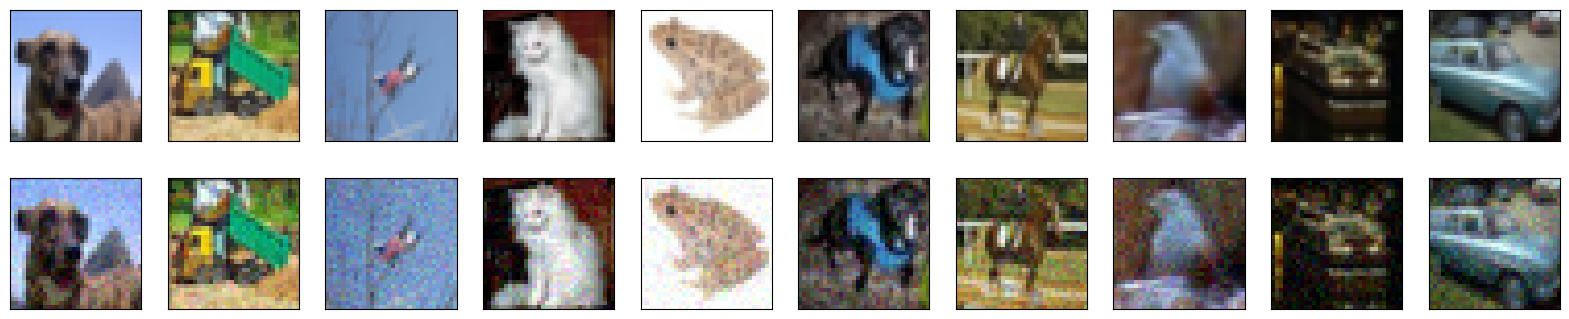

In [ ]:
# Since we only need images from the dataset to encode and decode, we
# won't use the labels.
(train_data, _), (test_data, _) = cifar10.load_data()
train_data.shape
# Normalize and reshape the data
train_data = preprocess(train_data)
test_data = preprocess(test_data)

# Create a copy of the data with added noise
noise_factor=0.05
noisy_train_data = noise(train_data,noise_factor)
noisy_test_data = noise(test_data,noise_factor)

# Display the train data and a version of it with added noise
display(train_data, noisy_train_data)

## Build the autoencoder

We are going to use the Functional API to build our convolutional autoencoder.

In [ ]:
input = layers.Input(shape=(32, 32, 3))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)#from relu to elu
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)#addition of 2 layers
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)#addition of a layer
x = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x) #input = noisy image, x=target clean image
#optimizer with scheduled decay
# Using adam optimizer with initial learning rate as 1e-3, changing learning rate after 5000 steps to 5e-4
optim = Adam(
    learning_rate=schedules.PiecewiseConstantDecay(
        boundaries=[5000], values=[1e-3, 5e-4]
    )
)
#model compilation
autoencoder.compile(optimizer=optim, loss="mse")
#model summary
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 128)         7385

let's train it using the noisy
data as our input and the clean data as our target. We want our autoencoder to
learn how to denoise the images.

In [ ]:
autoencoder.fit(
    x=noisy_train_data,
    y=train_data,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(noisy_test_data, test_data),
)

Epoch 1/50
391/391 [==============================] - 21s 20ms/step - loss: 0.0182 - val_loss: 0.0100
Epoch 2/50
391/391 [==============================] - 6s 16ms/step - loss: 0.0092 - val_loss: 0.0083
Epoch 3/50
391/391 [==============================] - 6s 16ms/step - loss: 0.0078 - val_loss: 0.0069
Epoch 4/50
391/391 [==============================] - 6s 16ms/step - loss: 0.0066 - val_loss: 0.0062
Epoch 5/50
391/391 [==============================] - 6s 16ms/step - loss: 0.0061 - val_loss: 0.0058
Epoch 6/50
391/391 [==============================] - 6s 16ms/step - loss: 0.0057 - val_loss: 0.0057
Epoch 7/50
391/391 [==============================] - 6s 16ms/step - loss: 0.0055 - val_loss: 0.0053
Epoch 8/50
391/391 [==============================] - 6s 16ms/step - loss: 0.0052 - val_loss: 0.0050
Epoch 9/50
391/391 [==============================] - 6s 17ms/step - loss: 0.0050 - val_loss: 0.0049
Epoch 10/50
391/391 [==============================] - 6s 16ms/step - loss: 0.0049 - val_l

Let's now predict on the noisy data and display the results of our autoencoder.

Notice how the autoencoder does an amazing job at removing the noise from the
input images.

313/313 [==============================] - 1s 2ms/step


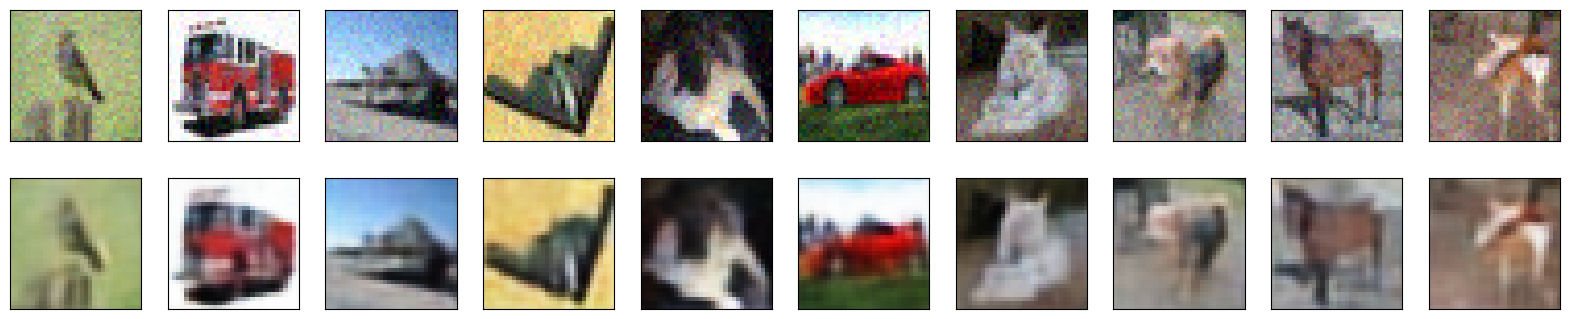

In [ ]:
predictions = autoencoder.predict(noisy_test_data)
display(noisy_test_data, predictions)